In [40]:
import bloqade.tsim
from bloqade import squin
import numpy as np
import stim
import tsim
import time

In [41]:
@squin.kernel
def main():
    q = squin.qalloc(3)
    squin.broadcast.reset(q)
    squin.h(q[0])
    squin.t(q[0])
    squin.h(q[0])
    squin.cx(q[0], q[2])
    for i in [0, 2]:
        squin.depolarize(0.5, q[i])
        squin.cx(q[i], q[1])
    squin.measure(q[1])
    squin.cx(q[1], q[0])
    squin.broadcast.measure([q[0], q[2]])

In [42]:
c = bloqade.tsim.Circuit(main)
c.diagram(height=150)

In [43]:
sampler = c.compile_sampler()

In [44]:
samples = sampler.sample(shots=1_000_000)
assert np.all(samples[:, 1] == samples[:, 2])
samples

array([[ True, False, False],
       [ True,  True,  True],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]], shape=(1000000, 3))

In [45]:
c.diagram("pyzx", scale=35);

Here, TSIM makes use of ZX diagrams in _doubled_ notation:


<img src="../figures/doubling.png" alt="doubled notation" width=650px>

In [46]:
tsim.Circuit("M 0").diagram("pyzx");

In [47]:
tsim.Circuit("""
    X 0
    R 0
""").diagram("pyzx");

In [48]:
tsim.Circuit(
"""
M !0
CNOT rec[-1] 1
""").diagram("pyzx");

Pauli Channels are represented as parameterized Pauli vertices:

In [49]:
tsim.Circuit(
    """
    X_ERROR(0.01) 0
    Y_ERROR(0.01) 1
    Z_ERROR(0.01) 2
""").diagram("pyzx");

In [50]:
tsim.Circuit("""DEPOLARIZE2(0.01) 0 1""").diagram("pyzx");

For QEC experiments, we are often not interested in measurements themselves, but certain XOR combinations of them, referred to as _detectors_. We can directly represent detectors in ZX diagrams by applying classical XORs to measurement bits. The XOR has a simple ZX representation:

<img src="../figures/xor.png" alt="XOR gate" width=350px>

In [51]:
c = tsim.Circuit("""
    R 0 1
    H 0
    CNOT 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
""")
c.diagram("pyzx");

In [52]:
sampler = c.compile_sampler()
sampler.sample(10)

array([[ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False]])

In [53]:
detector_sampler = c.compile_detector_sampler()
detector_sampler.sample(10)

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [54]:
c = tsim.Circuit("""
    RX 0
    R 1 2 3 4 5
    T 0
    H 0
    CNOT 0 2
    CNOT 0 3
    CNOT 2 5
    TICK
    CX 0 1 3 4
    X_ERROR(0.01) 0 1 3 4
    TICK
    CX 2 1 5 4
    X_ERROR(0.01) 2 1 5 4
    TICK
    MR 1 4
    DETECTOR rec[-2]
    DETECTOR rec[-1]
    TICK
    CX 0 1 3 4
    X_ERROR(0.01) 0 1 3 4
    TICK
    CX 2 1 5 4
    X_ERROR(0.01) 2 1 5 4
    TICK
    MR 1 4
    DETECTOR rec[-2] rec[-4]
    DETECTOR rec[-1] rec[-3]
    M 0 2 3 5
    DETECTOR rec[-3] rec[-4] rec[-6]
    DETECTOR rec[-1] rec[-2] rec[-5]
    OBSERVABLE_INCLUDE(0) rec[-3]
    OBSERVABLE_INCLUDE(1) rec[-1]
""")

In [55]:
c.diagram(height=200)

In [56]:
c.diagram("pyzx", scale=30, scale_horizontally=1.4);

In [57]:
c.diagram("pyzx-dets", transform_error_basis=True, scale_horizontally=2);

# Clifford sampling

In [58]:
p = 1e-6
stim_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=7,
    distance=7,
    before_round_data_depolarization=p,
    before_measure_flip_probability=p,
    after_clifford_depolarization=p,
    after_reset_flip_probability=p,
)
circuit = tsim.Circuit.from_stim_program(stim_circuit)
sampler = circuit.compile_detector_sampler()

stim_sampler = stim_circuit.compile_detector_sampler()

In [59]:
circuit.without_noise().diagram("timeslice-svg", height=250, rows=1)

In [60]:
# circuit.diagram("pyzx", scale_horizontally=2)

In [61]:
num_samples = 1024 **2 * 64

start = time.perf_counter()
samples = sampler.sample(shots=num_samples)
end = time.perf_counter()
print(f"Time per shot (tsim): {(end - start) * 1e9 / num_samples:.1f} ns")

Time per shot (tsim): 5.0 ns


In [62]:
num_samples = 1024
repeats = 1024 * 8

start = time.perf_counter()
for _ in range(repeats):
    samples = stim_sampler.sample(shots=num_samples)
end = time.perf_counter()
print(f"Time per shot (stim): {(end - start) * 1e9 / num_samples / repeats:.1f} ns")

Time per shot (stim): 315.6 ns


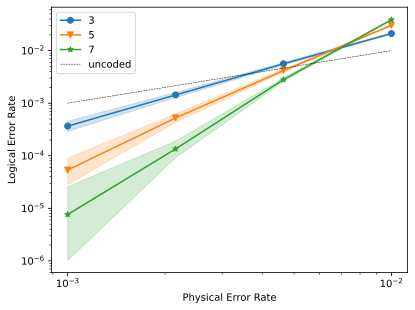

In [63]:
import sinter
import matplotlib.pyplot as plt

noise_vals = np.logspace(-3, -2, 4)
tasks = [
    sinter.Task(
        circuit=tsim.Circuit.from_stim_program(
            stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                distance=distance,
                rounds=distance,
                after_clifford_depolarization=noise,
                before_round_data_depolarization=noise,
                before_measure_flip_probability=noise,
                after_reset_flip_probability=noise,
            )
        ).cast_to_stim(),
        json_metadata={"p": noise, "distance": distance, "rounds": 3},
    )
    for noise in noise_vals
    for distance in [3, 5, 7]
]

collected_stats = sinter.collect(
    num_workers=8,
    tasks=tasks,
    decoders=["pymatching"],
    max_shots=1024 * 256,
    start_batch_size=1024 * 256,
    max_batch_size=1024 * 256,
)

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["distance"],
    failure_units_per_shot_func=lambda stats: stats.json_metadata["rounds"],
)
plt.plot(noise_vals, noise_vals, color="k", linestyle="--", lw=0.5, label="uncoded")
ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate")
ax.legend();

## Non-Clifford circuits

In [64]:
c = tsim.Circuit.from_file("../circuits/msd_5.stim")
c.diagram(height=500)

In [65]:
c.diagram("pyzx-dets")

Graph(111 vertices, 103 edges)

In [66]:
sampler = c.compile_detector_sampler()

In [67]:
num_samples = 50_000

start = time.perf_counter()
samples = sampler.sample(shots=num_samples)
end = time.perf_counter()
print(f"Time per shot (tsim): {(end - start) * 1e6 / num_samples:.2f} us")

Time per shot (tsim): 15.30 us


On GPU, time per shot is about $0.6 \mu s$.

In [68]:
sampler = c._stim_circ.compile_detector_sampler()

start = time.perf_counter()
num_samples = 1024
repeats = 1024
for i in range(repeats):
    samples = sampler.sample(shots=num_samples)
end = time.perf_counter()
print(f"Time per shot (stim): {(end - start) * 1e6 / num_samples / repeats:.2f} us")


Time per shot (stim): 0.55 us


In [69]:
c = tsim.Circuit.from_file("../circuits/msc_3.stim")
print(c.tcount())
c.diagram("timeslice-svg", height=200, rows=1)

16


In [70]:
c.diagram("pyzx-dets")

Graph(120 vertices, 149 edges)

In [71]:
sampler = c.compile_detector_sampler()

In [72]:
sampler.sample(100)

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ...,  True, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]], shape=(100, 32))

On GPU, Tsim achieved $100 \mu s$ per shot. However, the performance for this circuit has been improved by to $1\mu s$ on CPU in https://arxiv.org/pdf/2509.08658.